In [1]:
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current working directory
cwd = os.getcwd()

# Ensure that the path is starting in the scripts directory
if not cwd.split('/')[-1] == 'scripts':
    os.chdir(os.path.join(cwd, 'scripts'))

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [4]:
# Load Datasets
mut_file = os.path.join('..', 'data', 'pancan_mutation_freeze.tsv.gz')
sample_freeze_file = os.path.join('..', 'data', 'sample_freeze.tsv')
copy_loss_file = os.path.join('..', 'data', 'copy_number_loss_status.tsv.gz')
copy_gain_file = os.path.join('..', 'data', 'copy_number_gain_status.tsv.gz')
cancer_genes_file = os.path.join('..', 'data', 'vogelstein_cancergenes.tsv')

mutation_df = pd.read_table(mut_file, index_col=0)
sample_freeze = pd.read_table(sample_freeze_file, index_col=0)
copy_loss_df = pd.read_table(copy_loss_file, index_col=0)
copy_gain_df = pd.read_table(copy_gain_file, index_col=0)
cancer_genes_df = pd.read_table(cancer_genes_file)

In [5]:
# Load Ras Pathway Genes
results_path= os.path.join('..', 'classifiers', 'RAS')

# Load Ras Pathway Genes
genes_file = os.path.join('..', 'data', 'ras_genes.csv')
genes_df = pd.read_table(genes_file)

In [6]:
genes_df.head()

,genes,og_tsg
0,ALK,OG
1,ARAF,OG
2,BRAF,OG
3,EGFR,OG
4,ERBB2,OG


In [7]:
# Subset mutation data
mutation_sub_df = mutation_df.loc[:, genes_df['genes']]

In [8]:
# Find if the input genes are in this master list
genes_sub = cancer_genes_df[cancer_genes_df['Gene Symbol'].isin(genes_df['genes'])]

In [9]:
# Add status to the Y matrix depending on if the gene is a tumor suppressor
# or an oncogene. An oncogene can be activated with copy number gains, but
# a tumor suppressor is inactivated with copy number loss
tumor_suppressor = genes_df[genes_df['og_tsg'] == 'TSG']
oncogene = genes_df[genes_df['og_tsg'] == 'OG']

# Subset copy number information
copy_loss_sub_df = copy_loss_df[tumor_suppressor['genes']]
copy_gain_sub_df = copy_gain_df[oncogene['genes']]

## Output Mutation, Copy Number, and Total Heatmap (Gene by Cancer-type)

In [10]:
mutation_sub_total_df = mutation_sub_df.assign(Total=mutation_sub_df.max(axis=1))
mut_disease_df = mutation_sub_total_df.merge(sample_freeze, left_index=True,
                                             right_on='SAMPLE_BARCODE')
mut_heatmap_df = mut_disease_df.groupby('DISEASE').mean()

In [11]:
gene_avg = mut_disease_df.mean()
gene_avg.name = 'Total'

In [12]:
mut_heatmap_df = mut_heatmap_df.append(gene_avg)

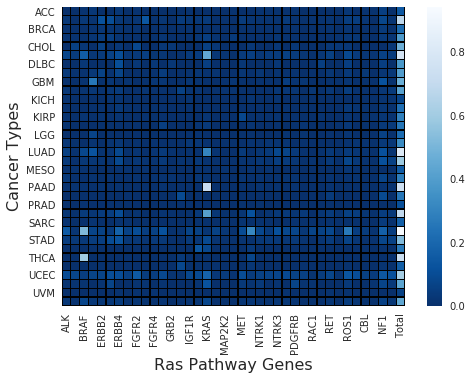

In [13]:
sns.set_style("whitegrid")
sns.heatmap(mut_heatmap_df, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True, cbar=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.savefig(os.path.join(results_path, 'mut_df.pdf'))

In [14]:
copy_df = pd.concat([copy_gain_sub_df, copy_loss_sub_df], axis=1)
copy_total_df = copy_df.assign(Total=copy_df.max(axis=1))
copy_disease_df = copy_total_df.merge(sample_freeze, left_index=True,
                                      right_on='SAMPLE_BARCODE')
copy_heatmap_df = copy_disease_df.groupby('DISEASE').mean()

In [15]:
copy_avg = copy_disease_df.mean()
copy_avg.name = 'Total'

In [16]:
copy_heatmap_df = copy_heatmap_df.append(copy_avg)

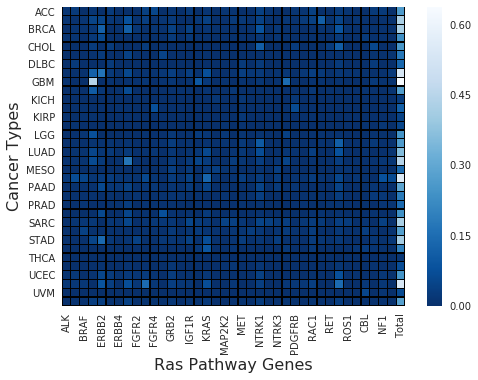

In [17]:
sns.set_style("whitegrid")
sns.heatmap(copy_heatmap_df, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.savefig(os.path.join(results_path, 'copy_df.pdf'))

In [18]:
# Combined heatmap
comb_heat = mutation_sub_df + copy_df
comb_heat[comb_heat == 2] = 1  # Replace duplicates with just one

In [19]:
comb_heat_df = comb_heat.merge(sample_freeze, left_index=True, right_on='SAMPLE_BARCODE')
comb_heat_total_df = comb_heat_df.assign(Total=comb_heat_df.max(axis=1))
comb_heatmap_df = comb_heat_total_df.groupby('DISEASE').mean()

In [20]:
comb_avg = comb_heat_total_df.mean()
comb_avg.name = 'Total'

In [21]:
comb_heatmap_plot = comb_heatmap_df.append(comb_avg)

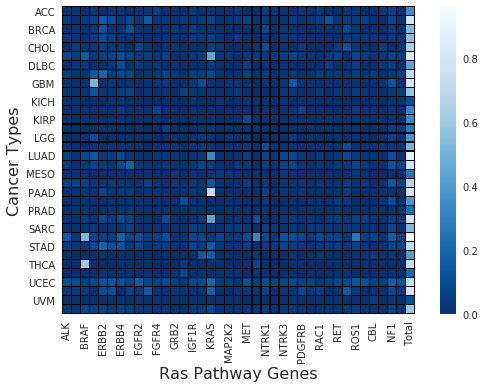

In [22]:
sns.set_style("whitegrid")
sns.heatmap(comb_heatmap_plot, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'combined_df.pdf'))

## Generating Pathway Mapper Text Files

In [23]:
summary_score_df = (
    pd.DataFrame(
        [mut_heatmap_df.loc['Total', :], copy_heatmap_df.loc['Total', :]]
    )
    .transpose()
)
summary_score_df.columns = ['mutation', 'copy_number']
summary_score_df = summary_score_df * 100
summary_score_df = summary_score_df.round(decimals = 1)

In [24]:
# Create negative percentages for tumor suppressors in the Ras Pathway
tum_sup_mult = pd.Series([1] * 34 + [-1] * 4 + [1])
tum_sup_mult.index = summary_score_df.index

In [25]:
summary_score_df = summary_score_df.mul(tum_sup_mult, axis=0)
pathway_mapper_file = os.path.join(results_path, 'tables',
                                   'pathwaymapper_percentages.txt')
summary_score_df.to_csv(pathway_mapper_file, sep='\t')

## Output number of Ras events per sample

In [26]:
decision_file = os.path.join(results_path, 'classifier_decisions.tsv')
decisions_df = pd.read_table(decision_file)
decisions_df.head()

,SAMPLE_BARCODE,log10_mut,total_status,weight,NRAS,KRAS,HRAS,HRAS_gain,KRAS_gain,NRAS_gain,PATIENT_BARCODE,DISEASE,SUBTYPE,hypermutated,include
0,TCGA-02-0047-01,1.812913,0,0.357117,0,0,0,0,0,0,TCGA-02-0047,GBM,IDHwt,0,0
1,TCGA-02-0055-01,1.707570,0,0.530723,0,0,0,0,0,0,TCGA-02-0055,GBM,IDHwt,0,0
2,TCGA-02-2483-01,1.662758,0,0.642091,0,0,0,0,0,0,TCGA-02-2483,GBM,IDHmut-non-codel,0,0
3,TCGA-02-2485-01,1.748188,0,0.467431,0,0,0,0,0,0,TCGA-02-2485,GBM,IDHwt,0,0
4,TCGA-02-2486-01,1.755875,0,0.361267,0,0,0,0,0,0,TCGA-02-2486,GBM,IDHwt,0,0


In [27]:
other_ras_df = mutation_sub_df.drop(['KRAS', 'HRAS', 'NRAS'], axis=1)
other_ras_copy_df = copy_df.drop(['KRAS', 'HRAS', 'NRAS'], axis=1)
other_ras_all_df = comb_heat_df.drop(['KRAS', 'HRAS', 'NRAS'], axis=1)

In [28]:
total_ras_mutations = pd.DataFrame(other_ras_df.sum(axis=1), columns=['mutation_count'])
total_ras_copy_events = pd.DataFrame(other_ras_copy_df.sum(axis=1), columns=['copy_count'])
total_ras_all = pd.DataFrame(other_ras_all_df.sum(axis=1), columns=['all_count'])
total_ras_all.index = comb_heat_df['SAMPLE_BARCODE']

In [29]:
# Define output summary of mutation, copy, and total counts per sample by Ras pathway
count_summary = (
    decisions_df[['SAMPLE_BARCODE', 'DISEASE', 'weight']]
    .merge(total_ras_mutations, left_on='SAMPLE_BARCODE', right_index=True)
    )
hyper_samples = decisions_df[decisions_df['hypermutated'] == 1]['SAMPLE_BARCODE']
count_summary.loc[count_summary['SAMPLE_BARCODE'].isin(hyper_samples),
                  'mutation_count'] = 'hyper'
count_summary.head()

,SAMPLE_BARCODE,DISEASE,weight,mutation_count
0,TCGA-02-0047-01,GBM,0.357117,0
1,TCGA-02-0055-01,GBM,0.530723,0
2,TCGA-02-2483-01,GBM,0.642091,0
3,TCGA-02-2485-01,GBM,0.467431,1
4,TCGA-02-2486-01,GBM,0.361267,0


In [30]:
count_summary['mutation_count'].value_counts()

0        5649
1        2164
2         570
hyper     377
3         192
4          81
5          27
6          10
8           2
7           2
Name: mutation_count, dtype: int64

In [31]:
count_summary = total_ras_copy_events.merge(count_summary, left_index=True,
                                            right_on='SAMPLE_BARCODE')
count_summary = total_ras_all.merge(count_summary, left_index=True,
                                    right_on='SAMPLE_BARCODE')
count_summary = (
    decisions_df[['SAMPLE_BARCODE', 'total_status']]
    .merge(count_summary, left_on='SAMPLE_BARCODE', right_on='SAMPLE_BARCODE')
    )
count_summary.head()

,SAMPLE_BARCODE,total_status,all_count,copy_count,DISEASE,weight,mutation_count
0,TCGA-02-0047-01,0,0,0,GBM,0.357117,0
1,TCGA-02-0055-01,0,1,1,GBM,0.530723,0
2,TCGA-02-2483-01,0,1,1,GBM,0.642091,0
3,TCGA-02-2485-01,0,3,3,GBM,0.467431,1
4,TCGA-02-2486-01,0,0,0,GBM,0.361267,0


In [32]:
count_summary_file = os.path.join(results_path, 'tables',
                                  'ras_events_per_sample.tsv')
count_summary.to_csv(count_summary_file, sep='\t', index=False)